In [3]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.5*3.125, 1.5*1.5],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2, 'xtick.labelsize': 7*2, 'ytick.labelsize': 7*2
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz
import pathlib

In [4]:
data_dir = '../../data/conext_data'
cross_validations = 5
tested_vcas = ['meet', 'teams']

## Utility Functions

In [5]:
def load_model_trial(path):
    with open(path, 'rb') as fd:
        model_trial = pickle.load(fd)
    return model_trial

def fps_prediction_accuracy(pred, truth):
    if len(pred) != len(truth):
        raise ValueError('Length mismatch for predictions and ground truth!')
    n = len(pred)
    df = pd.DataFrame({'pred': pred.to_numpy(), 'truth': truth.to_numpy()})
    df['deviation'] = df['pred']-df['truth']
    df['deviation'] = df['deviation'].abs()
    return df['deviation'].apply(lambda x: int(x <= 2))

def parse_call_pcap_filename(file_path):
    fname = os.path.basename(file_path)
    fsp = fname[:-5].split('_')
    return int(fsp[0])/1000, int(fsp[1])/1000, int(fsp[2])/100, int(fsp[3])/100

## Lookup tables

In [6]:
model_name_lookup = {
        'IP/UDP-ML': 'framesReceivedPerSecond_ml_random_LSTATS-TSTATS_rf_regressor_full_video_conext_data_cv_{}_original',
        'IP/UDP-non-ML': 'framesReceivedPerSecond_frame-lookback_random_none_none_full_video_conext_data_cv_{}_original',
        'RTP-ML': 'framesReceivedPerSecond_rtp_ml_random_LSTATS-TSTATS_rf_regressor_full_video_conext_data_cv_{}_original',
        'RTP-non-ML': 'framesReceivedPerSecond_rtp_random_none_none_full_video_conext_data_cv_{}'
}

col_map = {
        'framesReceivedPerSecond_pred': 'Frames Per Second Prediction',
        'framesReceivedPerSecond_webrtc': 'Ground Truth Frames Per Second',
        'throughput_mean_mbps': 'Throughput Mean (Mbps)',
        'throughput_std_mbps': 'Throughput Jitter (Mbps)',
        'latency_mean_ms': 'Latency Mean (ms)',
        'latency_std_ms': 'Latency Jitter (ms)',
        'MAE': 'Mean Absolute Error (# frames)'
}

feature_map = {
    'l_mean': 'Packet size mean', 'l_std': 'Packet size standard deviation', 'l_min': 'Packet size min', 'l_max': 'Packet size max', 'l_q1': 'Packet size 25th percentile', 'l_q2': 'Packet size 50th percentile', 'l_q3': 'Packet size 75th percentile', 'l_num_pkts': 'Total number of packets', 'l_num_bytes': 'Total number of bytes', 'l_num_unique': 'Total number of unique packet sizes',
    't_mean': 'Packet IAT mean', 't_std': 'Packet IAT standard deviation', 't_min': 'Packet IAT min', 't_max': 'Packet IAT max', 't_q1': 'Packet IAT 25th percentile', 't_q2': 'Packet IAT 50th percentile', 't_q3': 'Packet IAT 75th percentile', 't_num_pkts': 'Total number of packets'
}

## Feature Importance Analysis

In [200]:
class FeatureImportanceVisualizer:
    def __init__(self, model_identifier):
        self.model_identifier = model_identifier
        
    def acquire_data(self):
        merged_data = {'Feature Importance': [], 'VCA': [], 'Feature': [], 'Cross Validation': []}
        for cv in range(1, cross_validations+1):
            folder_name = model_name_lookup[self.model_identifier].format(cv)
            model_trial_path = f'{data_dir}_intermediates/{folder_name}/{folder_name}.pkl'
            model_trial = load_model_trial(model_trial_path)
            with open(f'{data_dir}_intermediates/{model_trial.trial_id}/{model_trial.trial_id}_vca_model.pkl', 'rb') as fd:
                vca_model = pickle.load(fd)
                for vca in vca_model:
                    f_imp = vca_model[vca].feature_importances
                    for feature in f_imp:
                        if f_imp[feature] == 0:
                            continue
                        merged_data['Feature Importance'].append(round(f_imp[feature]*100, 2))
                        merged_data['Feature'].append(feature)
                        merged_data['VCA'].append(vca)
                        merged_data['Cross Validation'].append(cv)
        return pd.DataFrame(merged_data)

    def visualize(self):
        df_merged = self.acquire_data()
        n_cols = len(df_merged['VCA'].unique())
        fig, ax = plt.subplots(n_cols, 1, figsize=(20, 18))
        idx = 0
        for vca in df_merged['VCA'].unique():
            if n_cols <= 1:
                axis = ax
            else:
                axis = ax[idx]
            axis.set_title(f'VCA = {vca}')
            axis.set_ylim([0, 100])
            axis.grid(visible=1)
            g = sns.barplot(data=df_merged[df_merged['VCA'] == vca], x = 'Feature', y = 'Feature Importance', ax=axis, errorbar=None)
            # for i in g.containers:
            #     g.bar_label(i,fmt='%.1f')
            idx += 1
        plt.suptitle(f'Model = {self.model_identifier}')
        plt.show()

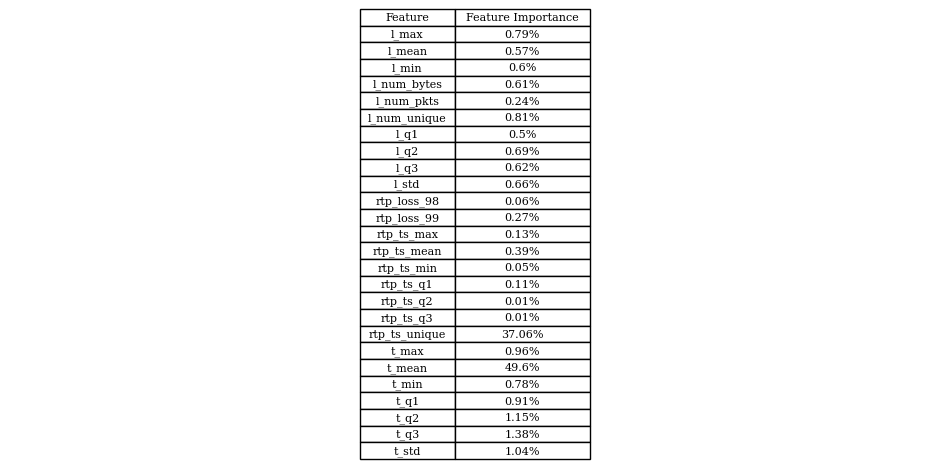

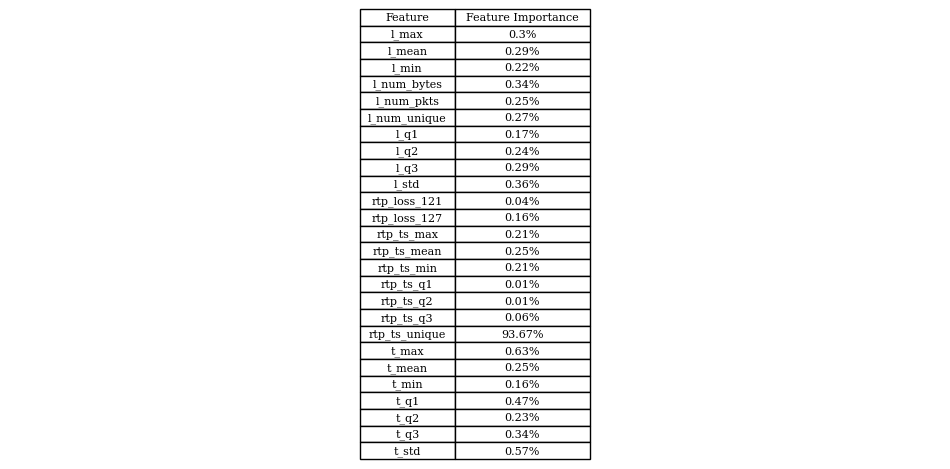

In [209]:
fig, ax =plt.subplots(figsize=(12,4))
# ax.axis('tight')
ax.axis('off')
df = FeatureImportanceVisualizer('RTP-ML').acquire_data()
dfg = df[df['VCA'] == 'meet'][['Feature', 'Feature Importance']].groupby(['Feature'])['Feature Importance'].mean().reset_index()
dfg['Feature Importance'] = dfg['Feature Importance'].apply(lambda x: str(round(x, 2))+'%')
# dfg['Feature'] = dfg['Feature'].apply(lambda x: feature_map[x])
t = ax.table(cellText=dfg.values,colLabels=dfg.columns,loc='center', cellLoc='center')
t.auto_set_font_size(False)
t.set_fontsize(8)
t.auto_set_column_width(col=list(range(len(dfg.columns))))
# fig.savefig('plots/conext_data/feature_importance_meet.pdf')

fig, ax =plt.subplots(figsize=(12,4))
ax.axis('off')
df = FeatureImportanceVisualizer('RTP-ML').acquire_data()
dfg = df[df['VCA'] == 'teams'][['Feature', 'Feature Importance']].groupby(['Feature'])['Feature Importance'].mean().reset_index()
dfg['Feature Importance'] = dfg['Feature Importance'].apply(lambda x: str(round(x, 2))+'%')
# dfg['Feature'] = dfg['Feature'].apply(lambda x: feature_map[x])
t = ax.table(cellText=dfg.values,colLabels=dfg.columns,loc='center', cellLoc='center')
t.auto_set_font_size(False)
t.set_fontsize(8)
t.auto_set_column_width(col=list(range(len(dfg.columns))))
# fig.savefig('plots/conext_data/feature_importance_teams.pdf')

## Analysis over network conditions

In [261]:
class NetworkConditionVisualizer:
    
    def __init__(self, model_identifiers):
        self.model_identifiers = model_identifiers
        
    
    def acquire_data(self):
        data = []
        for cv in range(1, cross_validations+1):
            for model_identifier in self.model_identifiers:
                folder_name = model_name_lookup[model_identifier].format(cv)
                model_trial_path = f'{data_dir}_intermediates/{folder_name}/{folder_name}.pkl'
                model_trial = load_model_trial(model_trial_path)
                with open(f'{data_dir}_intermediates/{model_trial.trial_id}/{model_trial.trial_id}_predictions.pkl', 'rb') as fd:
                    preds = pickle.load(fd)
                for vca in tested_vcas:
                    pred_merged = pd.concat(preds[vca], axis=0)
                    pred_merged = pred_merged.rename(columns = {f'{model_trial.metric}_{model_trial.estimation_method}': 'framesReceivedPerSecond_pred'})
                    pred_merged['Deviation'] = pred_merged['framesReceivedPerSecond_pred'] - pred_merged[f'{model_trial.metric}_webrtc']
                    pred_merged['MAE'] = pred_merged['Deviation'].apply(abs)
                    pred_merged['Accuracy'] = 100*fps_prediction_accuracy(pred_merged['framesReceivedPerSecond_pred'], pred_merged[f'{model_trial.metric}_webrtc'])
                    pred_merged['VCA'] = vca
                    pred_merged['Cross Validation'] = cv
                    pred_merged['Method'] = model_identifier
                    pred_merged['throughput_mean_mbps'], pred_merged['throughput_std_mbps'], pred_merged['latency_mean_ms'], pred_merged['latency_std_ms'] = zip(*pred_merged['file'].map(parse_call_pcap_filename))
                    data.append(pred_merged)
        return pd.concat(data, axis=0)
    
    def visualize(self, x, y, bins, y_bounds=None):
        df = self.acquire_data()
        bins += [df[x].max()]
        fig, ax = plt.subplots(1, len(self.model_identifiers))
        ax=[ax]
        labels = [f'[{round(bins[i])}-{round(bins[i+1])})' for i in range(len(bins)-1)]
        df[col_map[x]] = pd.cut(x = df[x], bins = bins, labels = labels, include_lowest = True)
        for i, method in enumerate(self.model_identifiers):
            sns.boxplot(x=col_map[x], y = y, hue='VCA', data=df[df['Method'] == method], ax = ax[i], whis=[10,90], showfliers=False)
            # ax[i].set_title(method)
            ax[i].set_xlabel(col_map[x])
            ax[i].set_ylabel(col_map[y])
            ax[i].tick_params(axis='x', rotation=45)
            if y_bounds:
                ax[i].set_ylim(y_bounds)
            ax[i].grid(visible=1)
        plt.show()
        return fig

### Ground truth FPS vs MAE

2.27 11310.27
0.0 7352.87


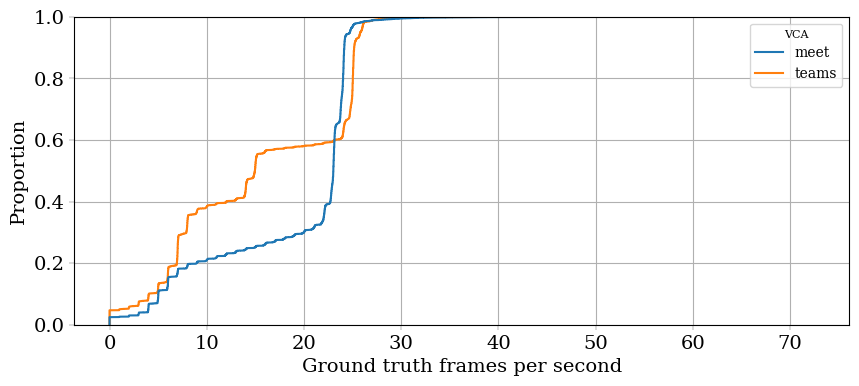

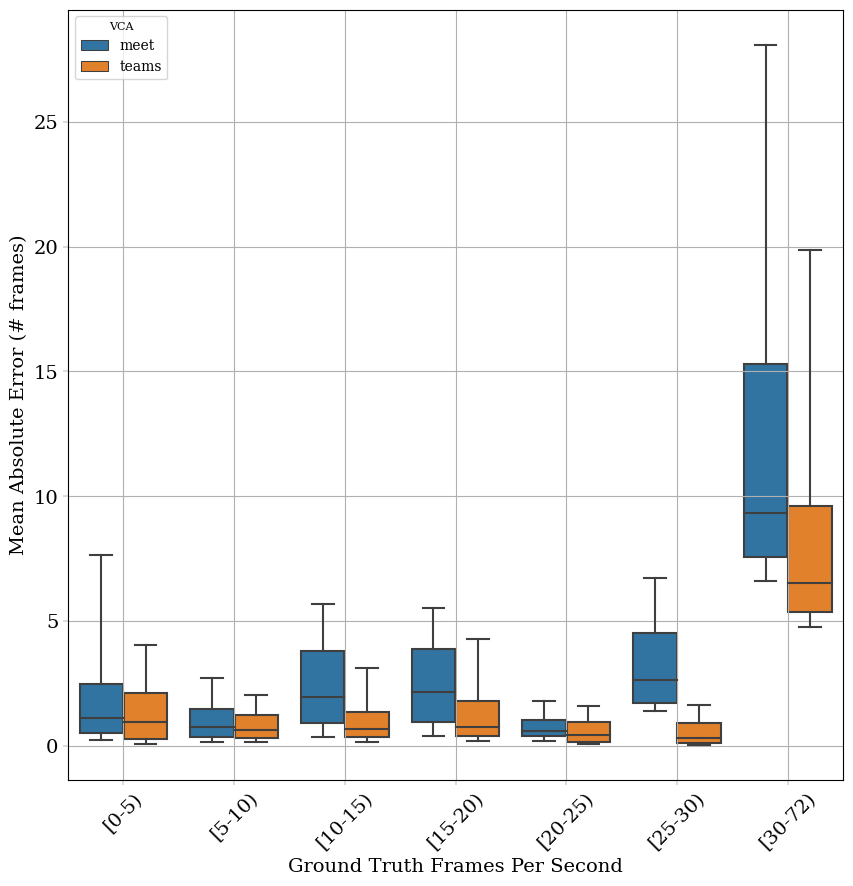

<AxesSubplot: xlabel='framesReceivedPerSecond_webrtc', ylabel='framesReceivedPerSecond_pred'>

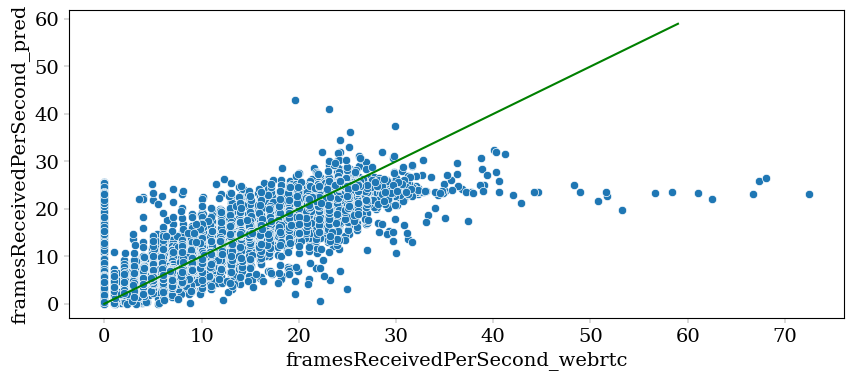

In [262]:
net_viz = NetworkConditionVisualizer(['IP/UDP-ML'])
df = net_viz.acquire_data()
print(df['latency_mean_ms'].min(), df['latency_mean_ms'].max())
print(df['latency_std_ms'].min(), df['latency_std_ms'].max())
plt.figure(figsize = (10, 4))
fig=sns.ecdfplot(x='framesReceivedPerSecond_webrtc', data=df, hue='VCA')
plt.xlabel('Ground truth frames per second')
# plt.xticks(np.arange(0, 70, 2))
plt.grid()
plt.savefig('plots/conext_data/ground_truth_fps_dist.pdf')
fig = net_viz.visualize('framesReceivedPerSecond_webrtc', 'MAE', bins=[0, 5, 10, 15, 20, 25, 30])
fig.savefig('plots/conext_data/mae_vs_ground_truth_fps.pdf')
f, a = plt.subplots(1, 1, figsize=(10, 4))
sns.scatterplot(x='framesReceivedPerSecond_webrtc', y='framesReceivedPerSecond_pred', data=df, ax=a)
sns.lineplot(x=list(range(60)), y=list(range(60)), c='g', ax=a)

- We see that for certain ground truth ranges, the MAE for meet is abnormally higher than teams. 
- For example, if we look at the 10-20 FPS interval in the above CDF plot, we see that less than 10% of the total samples fall within this range. The same applies to the intervals of 0-5, and also 25-108.
- This implies that the reason for high MAE for meet could just be a lack of training data.
- To address this problem, we could generate more data for these FPS ranges or sample fewer traces from more frequent FPS ranges to create a balanced training set. 

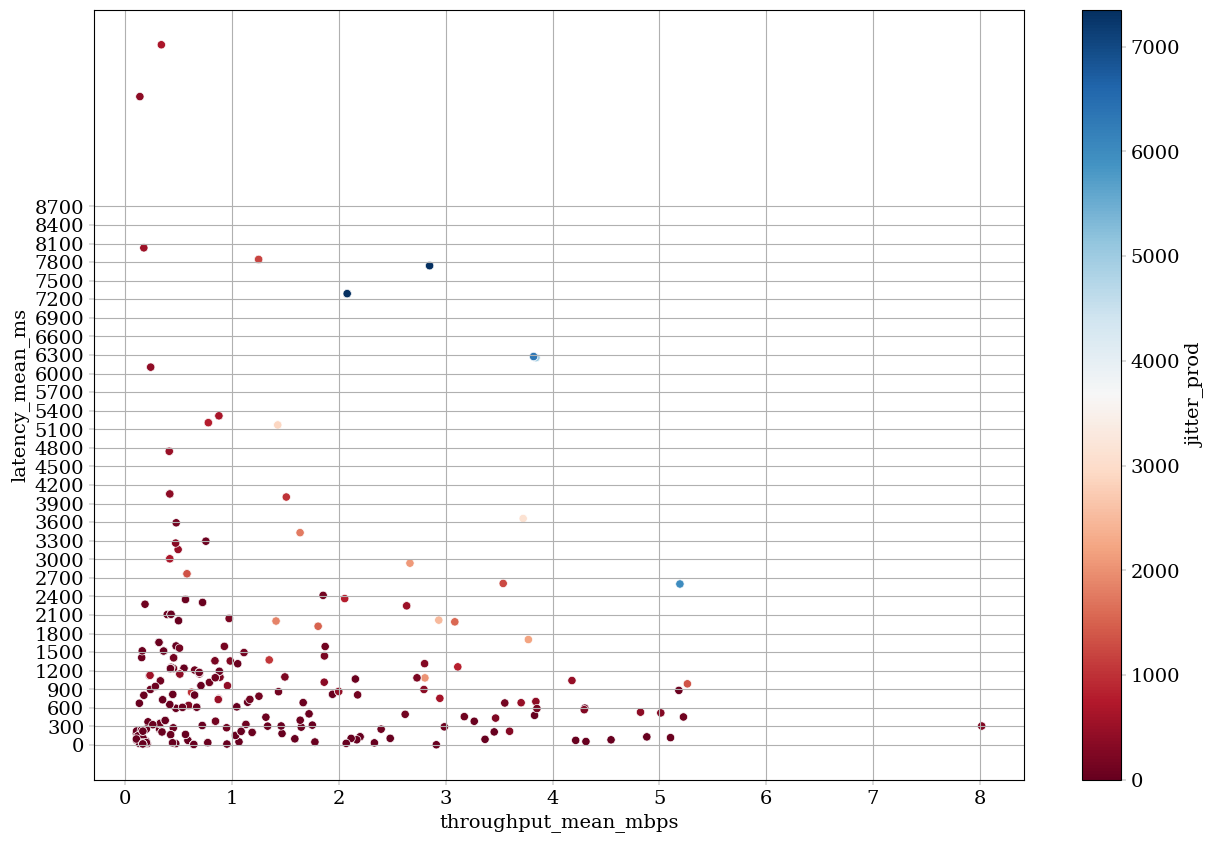

In [263]:
df = df[(df['framesReceivedPerSecond_webrtc'] >= 10) & (df['framesReceivedPerSecond_webrtc'] < 20) & (df['VCA'] == 'teams') & (df['Method'] == 'IP/UDP-ML')]
q90 = df['MAE'].quantile(0.9)
q10 = df['MAE'].quantile(0.1)
df = df[(df['MAE'] >= q10) & (df['MAE']) <= q90]
df = df[df['MAE'] > 2]
df['jitter_prod'] = df['throughput_std_mbps']*df['latency_std_ms']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.scatterplot(x='throughput_mean_mbps', y='latency_mean_ms', hue='jitter_prod', palette='RdBu', data=df)
norm = plt.Normalize(df['latency_std_ms'].min(), df['latency_std_ms'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
plt.yticks(np.arange(0, 9000, 300))
# Remove the legend and add a colorbar
ax.get_legend().remove()
plt.grid()
plt.colorbar(sm, ax=ax, label='jitter_prod')

### Distribution of predicted FPS

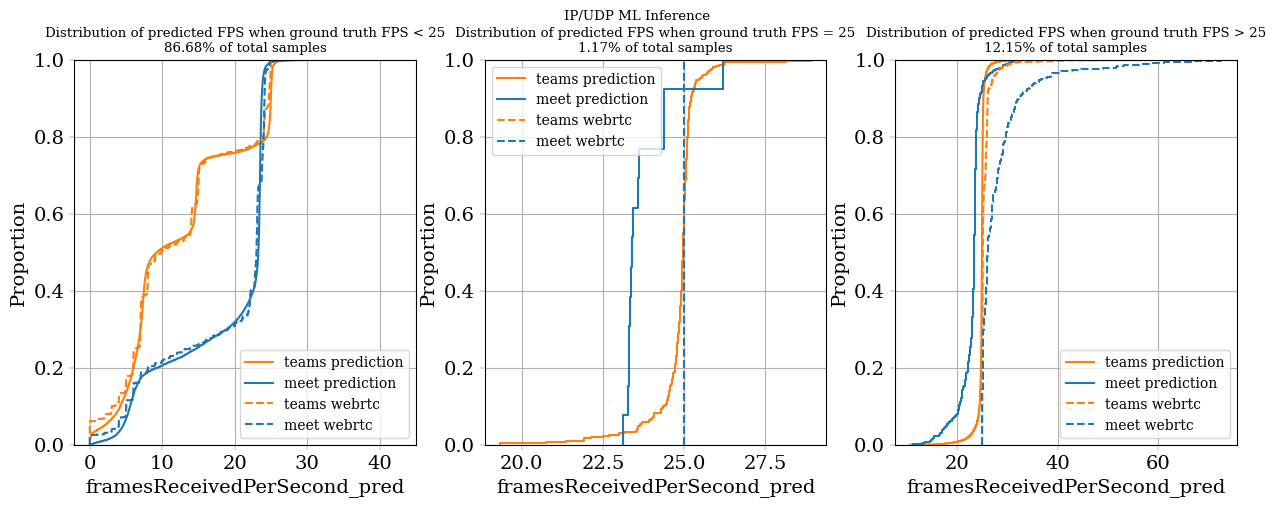

In [264]:
df = NetworkConditionVisualizer(['IP/UDP-ML']).acquire_data()
n = len(df)
# sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df)
# plt.grid()
# plt.show()

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
m = round(100*len(df[df['framesReceivedPerSecond_webrtc'] < 25])/n, 2)
sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] < 25], ax=ax[0])
ax[0].set_title(f'Distribution of predicted FPS when ground truth FPS < 25\n{m}% of total samples')
ax[0].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] < 25], ax=ax[0])
for line in ax[0].lines[-2:]:
    line.set_linestyle("--")
ax[0].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

m = round(100*len(df[df['framesReceivedPerSecond_webrtc'] == 25])/n, 2)
sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] == 25], ax=ax[1])
ax[1].set_title(f'Distribution of predicted FPS when ground truth FPS = 25\n{m}% of total samples')
ax[1].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] == 25], ax=ax[1])
for line in ax[1].lines[-2:]:
    line.set_linestyle("--")
ax[1].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

m = round(100*len(df[df['framesReceivedPerSecond_webrtc'] > 25])/n, 2)
sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] > 25], ax=ax[2])
ax[2].set_title(f'Distribution of predicted FPS when ground truth FPS > 25\n{m}% of total samples')
ax[2].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] > 25], ax=ax[2])
for line in ax[2].lines[-2:]:
    line.set_linestyle("--")
ax[2].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

plt.suptitle('IP/UDP ML Inference')
plt.show()

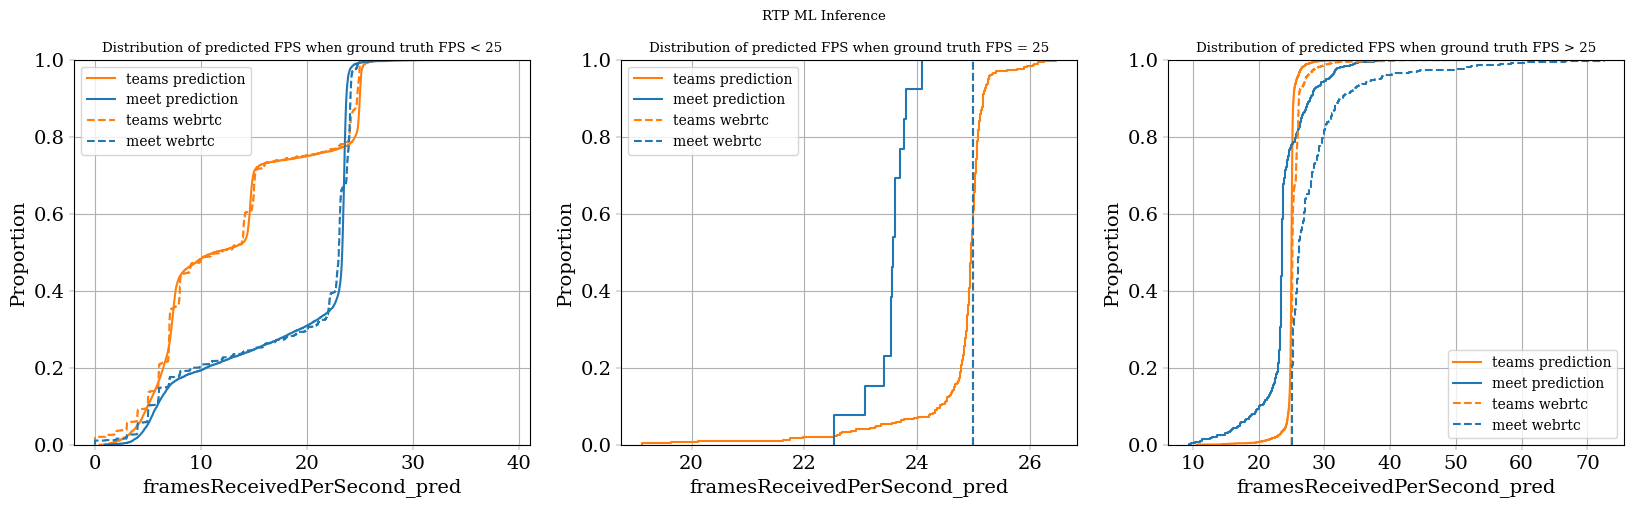

In [265]:
df = NetworkConditionVisualizer(['RTP-ML']).acquire_data()
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] < 25], ax=ax[0])
ax[0].set_title(f'Distribution of predicted FPS when ground truth FPS < 25')
ax[0].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] < 25], ax=ax[0])
for line in ax[0].lines[-2:]:
    line.set_linestyle("--")
ax[0].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] == 25], ax=ax[1])
ax[1].set_title(f'Distribution of predicted FPS when ground truth FPS = 25')
ax[1].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] == 25], ax=ax[1])
for line in ax[1].lines[-2:]:
    line.set_linestyle("--")
ax[1].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

sns.ecdfplot(x = 'framesReceivedPerSecond_pred', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] > 25], ax=ax[2])
ax[2].set_title(f'Distribution of predicted FPS when ground truth FPS > 25')
ax[2].grid()
sns.ecdfplot(x = 'framesReceivedPerSecond_webrtc', hue = 'VCA', data = df[df['framesReceivedPerSecond_webrtc'] > 25], ax=ax[2])
for line in ax[2].lines[-2:]:
    line.set_linestyle("--")
ax[2].legend(labels = ['teams prediction', 'meet prediction', 'teams webrtc', 'meet webrtc'])

plt.suptitle('RTP ML Inference')
plt.show()

### Mean Throughput vs MAE

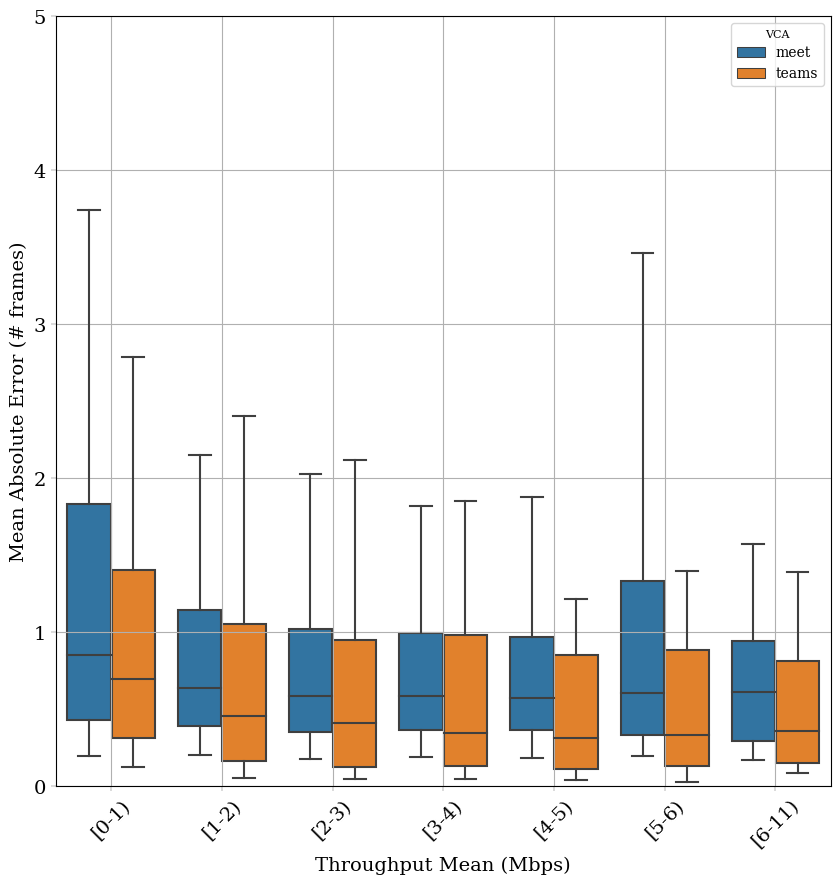

In [266]:
fig=NetworkConditionVisualizer(['IP/UDP-ML']).visualize('throughput_mean_mbps', 'MAE', y_bounds=[0, 5], bins=list(range(0, 7, 1)))
fig.savefig('plots/conext_data/mae_vs_tput.pdf')

### Throughput Jitter vs MAE

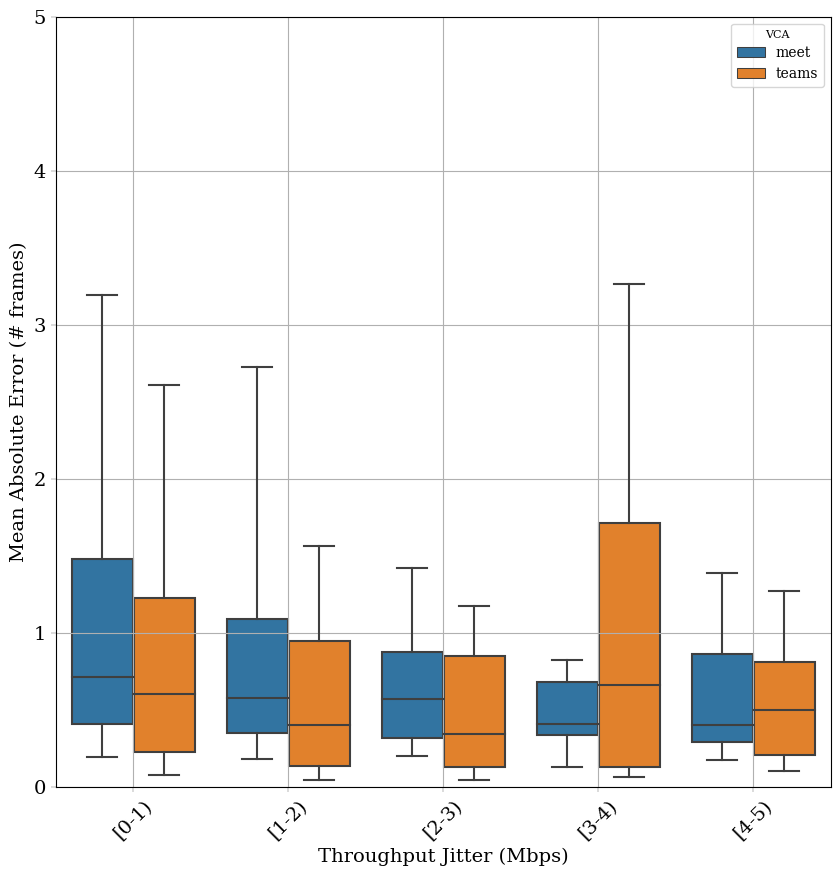

In [267]:
fig = NetworkConditionVisualizer(['IP/UDP-ML']).visualize('throughput_std_mbps', 'MAE', y_bounds=[0, 5], bins=[0, 1, 2, 3, 4])
fig.savefig('plots/conext_data/mae_vs_tput_jitter.pdf')

### Mean Latency vs MAE

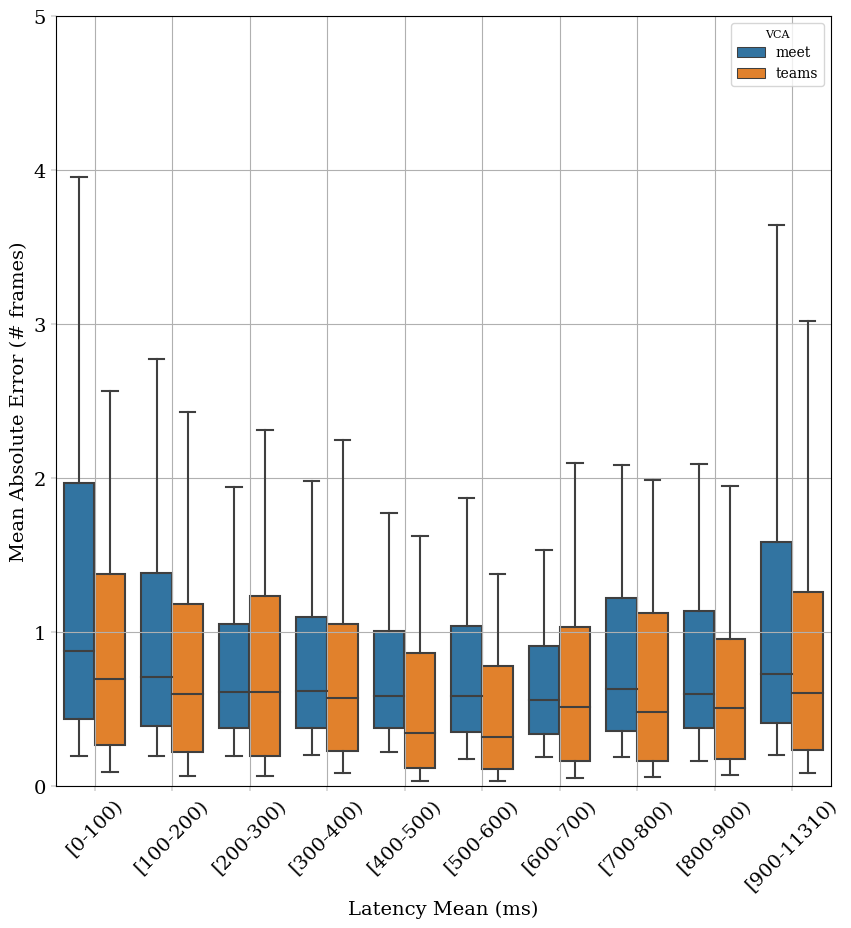

In [268]:
fig = NetworkConditionVisualizer(['IP/UDP-ML']).visualize('latency_mean_ms', 'MAE', y_bounds=[0, 5], bins=list(range(0, 1000, 100)))
fig.savefig('plots/conext_data/mae_vs_latency.pdf')

### Latency jitter vs MAE

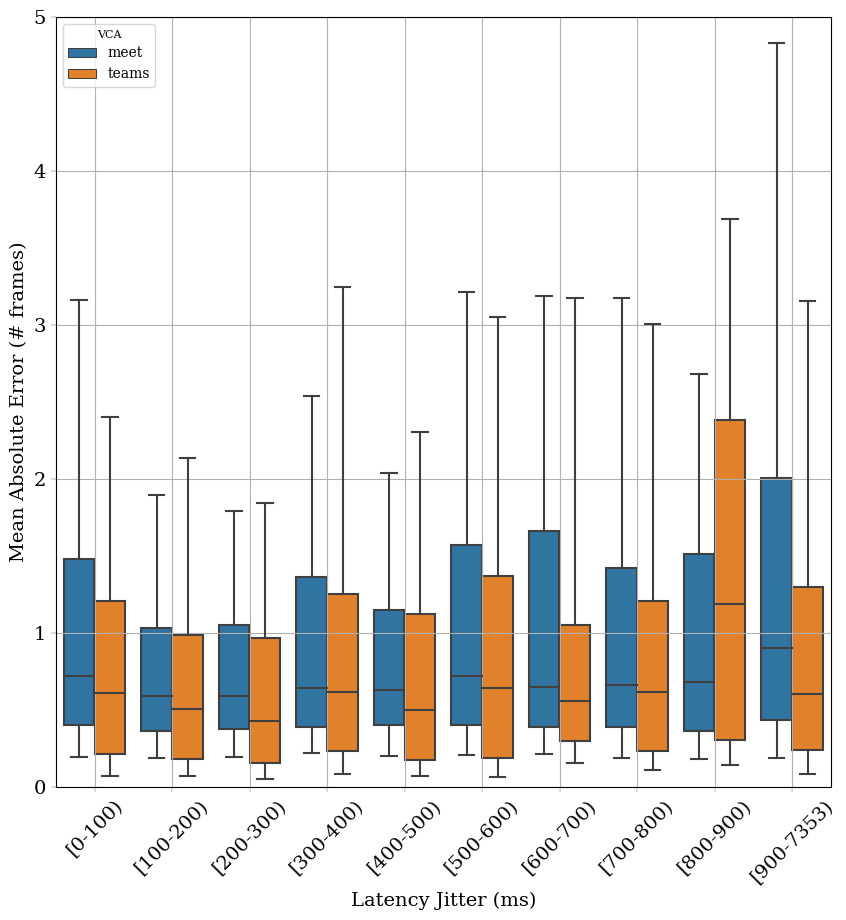

In [269]:
fig=NetworkConditionVisualizer(['IP/UDP-ML']).visualize('latency_std_ms', 'MAE', y_bounds=[0, 5], bins=list(range(0, 1000, 100)))
fig.savefig('plots/conext_data/mae_vs_latency_jitter.pdf')

## Inaccuracies in frame boundary estimation

In [3]:
%run '../qoe_estimation/frame_lookback/model.py'
%run '../config.py'

## Teams Lookahead tuning

In [170]:
for l in range(1, 15):
    trace = ('../../data/conext_data/logs_Teams_06-15_rush_hour/capture/102_37_19383_1550_53_1655422669.pcap', '../../data/conext_data/logs_Teams_06-15_rush_hour/capture/102_37_19383_1550_53_1655422669.csv', '../../data/conext_data/logs_Teams_06-15_rush_hour/webrtc/102_37_19383_1550_53_1655422669.json')
    csv_file = trace[1]
    webrtc_file = trace[2]
    net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
    df = pd.read_csv(csv_file, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii')
    if df['ip.proto'].dtype == object:
        df = df[df['ip.proto'].str.contains(',') == False]
    df = df[~df['ip.proto'].isna()]
    df['ip.proto'] = df['ip.proto'].astype(int)
    df = df[(df['ip.proto'] == 17) & (df['ip.dst'] == project_config['destination_ip']['conext_data'])]
    src = df.groupby('ip.src').agg({'udp.length': sum, 'rtp.p_type': 'count'}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.src'].iloc[0]
    df = df[df['ip.src'] == src]

    df = df[df['udp.length'] > 306]
    df = df.sort_values(by=['frame.time_relative'])
    marked = {i: False for i in range(df.shape[0])}
    frame_id_assignment = [-1 for _ in range(df.shape[0])]
    frame_id = 1
    for i in range(df.shape[0]):
        if marked[i]:
            continue
        s = df.iloc[i]['udp.length']
        for j in range(i, min(i+l, df.shape[0])):
            if not marked[j] and abs(df.iloc[j]['udp.length'] - s) <= 3:
                marked[j] = True
                frame_id_assignment[j] = frame_id
        frame_id += 1
    df["frame_num"] = frame_id_assignment
    df = df[df['frame_num'] != -1]
    df['udp.length'] = df['udp.length'] - 12

    df_grp_udp = df.groupby("frame_num").agg({"frame.time_epoch": list, "udp.length": list}).reset_index()
    df_grp_udp["frame_st"] = df_grp_udp["frame.time_epoch"].apply(lambda x: min(x))
    df_grp_udp["frame_et"] = df_grp_udp["frame.time_epoch"].apply(lambda x: max(x))
    # df_grp_udp = df_grp_udp[df_grp_udp['frame_et'] - df_grp_udp['frame_st'] <= self.max_buffer_time[self.vca]]
    df_grp_udp["frame_size"] = df_grp_udp["udp.length"].apply(lambda x: sum(x))
    df_grp_udp["ft_end"] = df_grp_udp['frame_et'].apply(lambda x: int(x)+1)

    df_grp_udp["frame_dur"] = df_grp_udp["frame_et"].diff()
    df_grp_udp["avg_frame_dur"] = df_grp_udp["frame_dur"].rolling(
        30).mean()  # Why 30?
    df_grp_udp = df_grp_udp.fillna(0)

    # freeze calculation
    df_grp_udp["is_freeze"] = df_grp_udp.apply(lambda x: is_freeze(x["frame_dur"], x["avg_frame_dur"]), axis=1)
    df_grp_udp["freeze_dur"] = df_grp_udp.apply(lambda x: get_freeze_dur(x["frame_dur"], x["avg_frame_dur"]), axis=1)

    df_grp_udp = df_grp_udp.groupby("ft_end").agg({"frame_size": ["count", "sum"], "is_freeze": "sum",
                                        "freeze_dur": "sum",
                                        "frame_dur": "std"}).reset_index()

    # rename columns
    df_grp_udp.columns = ['_'.join(col).strip('_')
                    for col in df_grp_udp.columns.values]
    df_grp_udp = df_grp_udp.rename(columns={'frame_size_count': 'predicted_framesReceived',
                                    'is_freeze_sum': 'freeze_count',
                                    'frame_size_sum': 'predicted_bitrate',
                                    'freeze_dur_sum': 'freeze_dur',
                                    'frame_dur_std': 'predicted_frame_jitter'
                                    })
    df_grp_udp['predicted_bitrate'] = df_grp_udp['predicted_bitrate']*8

    webrtc_reader = WebRTCReader(webrtc_file, 'conext_data')
    df_webrtc = webrtc_reader.get_webrtc()[['framesReceived', 'ts']]
    col = "ft_end"
    df_merge = pd.merge(df_grp_udp, df_webrtc, left_on=col, right_on="ts")
    metric_col = f'framesReceived_frame-lookback'
    webrtc_col = f'framesReceived_gt'
    df_merge = df_merge.rename(columns={f'predicted_framesReceived': metric_col, 'framesReceived': webrtc_col, 'ts': 'timestamp'})
    df_merge = df_merge[[webrtc_col, metric_col, 'timestamp']]
    df_merge = df_merge.dropna()
    mae = round(mean_absolute_error(df_merge[metric_col], df_merge[webrtc_col]), 2)
    print(f'L = {l}, MAE = {mae}')

L = 1, MAE = 3.82
L = 2, MAE = 1.14
L = 3, MAE = 1.16
L = 4, MAE = 1.28
L = 5, MAE = 1.32
L = 6, MAE = 1.38
L = 7, MAE = 1.44
L = 8, MAE = 1.45
L = 9, MAE = 1.46
L = 10, MAE = 1.54
L = 11, MAE = 1.61
L = 12, MAE = 1.64
L = 13, MAE = 1.64
L = 14, MAE = 1.63


## Meet Lookahead Tuning

In [18]:
csv_file = "../../data/conext_data/logs_Meet_06-15_rush_hour/capture/1010_78_3455_278_49_1655323428.csv"
net_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type', 'rtp.marker']
df = pd.read_csv(csv_file, header=None, sep='\t', names=net_columns, lineterminator='\n', encoding='ascii')
dfg = df.groupby('rtp.timestamp').agg(max_size=('udp.length', max), min_size = ('udp.length', min)).reset_index()
if df['ip.proto'].dtype == object:
    df = df[df['ip.proto'].str.contains(',') == False]
df = df[~df['ip.proto'].isna()]
df['ip.proto'] = df['ip.proto'].astype(int)
df = df[(df['ip.proto'] == 17) & (df['ip.dst'] == '192.168.1.107')]
src = df.groupby('ip.src').agg({'udp.length': sum, 'rtp.p_type': 'count'}).reset_index().sort_values(by='udp.length', ascending=False).head(1)['ip.src'].iloc[0]
df = df[df['ip.src'] == src]

df = df[df['udp.length'] > 306]
df = df.sort_values(by=['frame.time_relative'])
frame_id_assignment = [-1 for _ in range(df.shape[0])]
frame_id = 1
l = 1
for i in range(df.shape[0]):
    found = False
    s = df.iloc[i]['udp.length']
    for j in range(max(0, i-l), i):
        if abs(df.iloc[j]['udp.length'] - s) <= 1:
            frame_id_assignment[i] = frame_id
            found = True
            break
    if not found:
        frame_id += 1
        frame_id_assignment[i] = frame_id
df["frame_num"] = frame_id_assignment
dfc = df.groupby("frame_num").agg({"rtp.timestamp": (lambda x: len(set(x)))})
coal = len(dfc[dfc["rtp.timestamp"] > 1]) / len(dfc)
dfi = df.groupby("rtp.timestamp").agg({"frame_num": (lambda x: len(set(x)))})
il = len(dfi[dfi["frame_num"] > 1]) / len(dfi)

## 1. non-RTP packets

In [19]:
len(df[df['rtp.timestamp'].isna()]) / len(df)

0.002182214948172395

## 2. Coalesces and Interleaves

In [ ]:
from collections import defaultdict
df['et'] = df['frame.time_relative'].apply(int)
dfs = df[(df['et'] == 11)]
rtps = dfs['rtp.timestamp'].tolist()
fnums = dfs['frame_num'].tolist()
times = dfs['frame.time_relative'].tolist()
rtp_set = sorted(list(set(rtps)))
fnum_set = sorted(list(set(fnums)))
print(len(rtp_set), len(fnum_set))
rtp_idx = {rtp_set[i]: i for i in range(len(rtp_set))}
fnum_idx = {fnum_set[i]: i for i in range(len(fnum_set))}
rel = [(i, fnum_idx[fnums[i]]) for i in range(len(rtps))]
max_idx = defaultdict(lambda: -1)
for a, b in rel:
    max_idx[b] = max(max_idx[b], a)
top_x = [max_idx[x] for x in max_idx.keys()]
a_y_ = sorted(rtps)
b_y_ = sorted(fnums)
a_y = [rtp_idx[x] for x in a_y_]
b_y = [fnum_idx[x] for x in b_y_]
a_x = [1 for i in range(len(a_y))]
b_x = [2 for i in range(len(fnum_idx))]
plt.figure(figsize=(1.5*3.125, 1.5))
plt.scatter(list(range(len(a_y))), a_x, c='r')
plt.scatter(top_x, b_x, c='b')
plt.margins(y=0.2)
for i in range(len(rtps)):
    plt.annotate(xy=(i-0.5, 0.83), text=f'{rtp_idx[rtps[i]]+1}', fontsize=8)
for i in range(len(fnum_idx)):
    plt.annotate(xy=(max_idx[i]-0.5, 2+0.045), text=f'{i+1}', fontsize=8)
for i1, i2 in rel:
    if i1 in [1, 2, 3]:
        plt.annotate(xy=(i1,1), xytext=(max_idx[i2], 2), arrowprops=dict(arrowstyle='<-', ls = '--') , text='')
    else:
        plt.annotate(xy=(i1,1), xytext=(max_idx[i2], 2), arrowprops=dict(arrowstyle='<-') , text='')
plt.text(x =3, y = 0.6, s = 'Packet RTP Timestamps', fontsize=14)
plt.text(x =3, y = 2.3, s = 'Assigned frames', fontsize=14)
plt.yticks([])
plt.xticks([])
plt.box(False)
plt.savefig('paper_plots/coalesces.pdf', bbox_inches='tight')

11 13


In [32]:
df.groupby('et').agg({'rtp.timestamp': lambda x: len(set(x)), 'frame_num': lambda x: len(set(x))})

,rtp.timestamp,frame_num
et,,
4,2.00,2
10,2.00,2
11,11.00,13
12,25.00,25
13,24.00,24
...,...,...
67,24.00,27
68,23.00,24
69,25.00,27


In [34]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
dfs[['rtp.timestamp', 'frame_num', 'udp.length']]

,rtp.timestamp,frame_num,udp.length
1066,1880642379.0,6,1147.0
1069,1880642379.0,7,1159.0
1071,1880642379.0,7,1159.0
1073,1880642379.0,8,1155.0
1078,1880646069.0,9,396.0
1080,1880650209.0,10,550.0
1086,1880653179.0,11,583.0
1089,1880657319.0,12,898.0
1092,1880660199.0,13,567.0
1096,1880664339.0,14,617.0


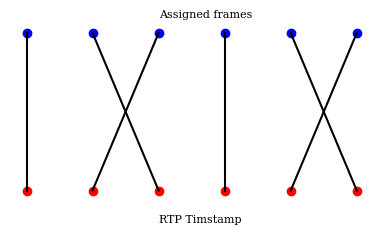

In [51]:
a = [1, 1, 1, 2, 3, 3]
b = [10, 10, 20, 30, 30, 50]
rel = [(0, 0), (1, 2), (2, 1), (3, 3), (4, 5), (5, 4)]
a_x = [1 for i in range(len(a))]
a_y = [i for i in range(len(a))]
b_x = [2 for i in range(len(b))]
b_y = [i for i in range(len(b))]
plt.scatter(a_y, a_x, c='r')
plt.scatter(b_y, b_x, c='b')
for i1, i2 in rel:
    plt.plot([i1, i2], [1, 2], 'k')
plt.text(x =2, y = 0.8, s = 'RTP Timstamp')
plt.text(x =2, y = 2.1, s = 'Assigned frames')
plt.yticks([])
plt.xticks([])
plt.box(False)

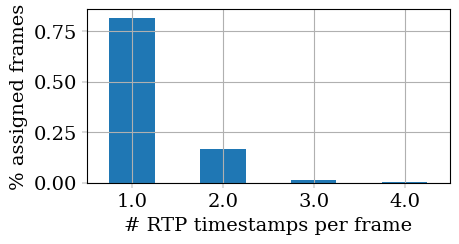

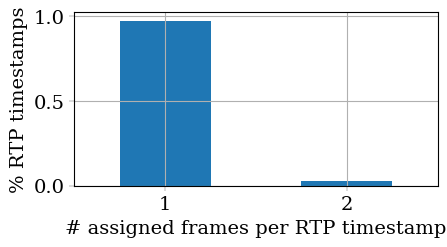

In [88]:
plt.figure()
dfc = df.groupby('frame_num').agg(ts_set=('rtp.timestamp', lambda x: len(set(x)))).reset_index()
dfc['ts_set'].value_counts(normalize=True).plot.bar(rot=0)
plt.ylabel('% assigned frames')
plt.xlabel('# RTP timestamps per frame')
plt.grid(visible=1)
plt.figure()
dfi = df.groupby('rtp.timestamp').agg(fid_set=('frame_num', lambda x: len(set(x)))).reset_index()
dfi['fid_set'].value_counts(normalize=True).plot.bar(rot=0)
plt.ylabel('% RTP timestamps')
plt.xlabel('# assigned frames per RTP timestamp')
plt.grid(visible=1)

<AxesSubplot: xlabel='FPS Deviation', ylabel='Proportion'>

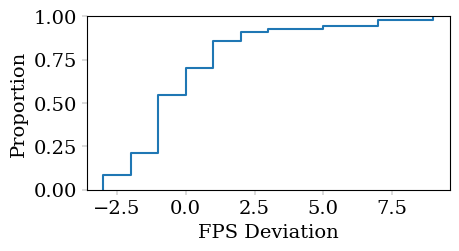

In [92]:
df_merge['FPS Deviation'] = df_merge['framesReceived_frame-lookback'] - df_merge['framesReceived_gt']
sns.ecdfplot(df_merge, x = 'FPS Deviation')

In [94]:
df_merge['FPS Deviation'].mean()

-0.03508771929824561

In [97]:
mean_absolute_error(df_merge['framesReceived_frame-lookback'], df_merge['framesReceived_gt'])

1.6491228070175439